# 모델1 : 전복

## 모델구성
- EDA결과 적용
  - 성별 원핫인코딩
  - 전체무게 - (살, 내장, 껍질)이 음수인 경우 삭제
  - 껍질의 넓이( a * b * π) 특성 추가
  - 껍질의 둘레( 2π*(0.5 * √(a^2 + b^2))) 특성 추가
- 모델
  - 은닉층9개
    - 은닉1 : 노드12 (특성 수=12)
    - 은닉2 : X2
    - 은닉3 : X2
    - 은닉4 : X2
    - 은닉5 : X2
    - 은닉6 : /2
    - 은닉7 : /2
    - 은닉8 : /2
    - 은닉9 : /2
  - Batch Normalization

## 가설 : 학습률조정으로 성능이 오를 것
- CosineDecay

## 결과
- 성능향상 없음
  - Test Loss : 6.651 / Accuracy  : 0.851

In [7]:
# Tensorflow Check
import tensorflow as tf
from tensorflow.python.client import device_lib
import sys
print(f'Python     : {sys.version.split("|")[0]}')
print(f'Tensorflow : {tf.__version__}')
print(f'TF GPU     : {"True" if device_lib.list_local_devices()[1] else "False"}')

Python     : 3.10.11 
Tensorflow : 2.10.1
TF GPU     : True


In [8]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow import keras
from IPython.display import clear_output
import json

# 각종 변수 선언
csv_path = 'D:/coding/aib/GPTeachersDay/TeamProject1/leeyeonjun/Data/Regression_data.csv'
EPOCHS = 1000
MB_SIZE = 1024

In [9]:
# 필요한 함수 / 메소드 정의
class EvalAccuracy(tf.keras.metrics.Metric):
    """
    사용자 정의 평가지표 : Accuracy
    """
    def __init__(self, name="accuracy", **kwargs):
        super(EvalAccuracy, self).__init__(name=name, **kwargs)
        self.correct = self.add_weight(name=name, initializer="zeros")

    def update_state(self, y_true, y_predict, sample_weight=None):
        value = tf.abs((y_predict - y_true) / y_true)
        self.correct.assign(tf.reduce_mean(value))

    def result(self):
        return 1 - self.correct

    def reset_state(self):
        self.correct.assign(0.)

class CustomCallback(keras.callbacks.Callback):
    """
    사용자 정의 콜백함수
    """
    def on_train_begin(self, logs=None):
        print("Starting training")

    def on_train_end(self, logs=None):
        print("End training")
        # clear_output(wait=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:print()
        if epoch % 10 == 0:
            print(f'{epoch} / ', end='')

def load_data(csv_path, TRAIN_RATIO=0.8):
    global X, y, X_train, X_test, y_train, y_test, df
    
    # 데이터셋 로드
    df = pd.read_csv(csv_path)
    
    # 전체무게가 음수인 경우 삭제
    minus_list = df['Whole weight'] - (df['Shucked weight'] + df['Viscera weight'] + df['Shell weight'])
    minus_list = minus_list[minus_list < 0]
    df.drop(minus_list.index, axis=0, inplace=True)
    
    # 껍질의 넓이 ( a * b * π)
    df['Area'] = 0.5 * df['Length'] * 0.5 * df['Diameter'] * np.pi
        
    # 껍질의 둘레 (근사) ( 2π*(0.5 * √(a^2 + b^2)))
    df['Perimeter'] = np.pi * np.sqrt(0.5 * ((df['Length'] ** 2) + (df['Diameter'] ** 2)))
    
    # 성별 원핫 인코딩
    df=pd.get_dummies(df,columns=['Sex'])
    
    # 학습 데이터 분리
    X = df.drop('Rings', axis=1)
    y = df['Rings'].astype('float32')
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_RATIO, random_state = 83)
    
    # MinMaxScaler
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)

def get_model(shape, node_n=12, dout=0.01):
    regularizer=keras.regularizers.L1L2(l1=0.001, l2=0.001)
    
    inputs  = keras.Input(shape=shape)
    
    dense1  = keras.layers.Dense(node_n
                                , kernel_regularizer=regularizer)(inputs)
    norm1   = keras.layers.BatchNormalization()(dense1)
    relu1   = keras.layers.Activation('relu')(norm1)
    dout1   = keras.layers.Dropout(dout)(relu1)
    
    dense2  = keras.layers.Dense(node_n*2
                                , kernel_regularizer=regularizer)(dout1)
    norm2   = keras.layers.BatchNormalization()(dense2)
    relu2   = keras.layers.Activation('relu')(norm2)
    dout2   = keras.layers.Dropout(dout)(relu2)
    
    dense3  = keras.layers.Dense(node_n*4
                                , kernel_regularizer=regularizer)(dout2)
    norm3   = keras.layers.BatchNormalization()(dense3)
    relu3   = keras.layers.Activation('relu')(norm3)
    dout3   = keras.layers.Dropout(dout)(relu3)
    
    dense4  = keras.layers.Dense(node_n*8
                                , kernel_regularizer=regularizer)(dout3)
    norm4   = keras.layers.BatchNormalization()(dense4)
    relu4   = keras.layers.Activation('relu')(norm4)
    dout4   = keras.layers.Dropout(dout)(relu4)
    
    dense5  = keras.layers.Dense(node_n*16
                                , kernel_regularizer=regularizer)(dout4)
    norm5   = keras.layers.BatchNormalization()(dense5)
    relu5   = keras.layers.Activation('relu')(norm5)
    dout5   = keras.layers.Dropout(dout)(relu5)
    
    concat1  = keras.layers.Concatenate(axis=1)([dout5, dout4])
    dense6  = keras.layers.Dense(node_n*8
                                , kernel_regularizer=regularizer)(concat1)
    norm6   = keras.layers.BatchNormalization()(dense6)
    relu6   = keras.layers.Activation('relu')(norm6)
    dout6   = keras.layers.Dropout(dout)(relu6)
    
    concat2  = keras.layers.Concatenate(axis=1)([dout6, dout3])
    dense7  = keras.layers.Dense(node_n*4
                                , kernel_regularizer=regularizer)(concat2)
    norm7   = keras.layers.BatchNormalization()(dense7)
    relu7   = keras.layers.Activation('relu')(norm7)
    dout7   = keras.layers.Dropout(dout)(relu7)
    
    concat3  = keras.layers.Concatenate(axis=1)([dout7, dout2])
    dense8  = keras.layers.Dense(node_n*2
                                , kernel_regularizer=regularizer)(concat3)
    norm8   = keras.layers.BatchNormalization()(dense8)
    relu8   = keras.layers.Activation('relu')(norm8)
    dout8   = keras.layers.Dropout(dout)(relu8)
    
    concat4  = keras.layers.Concatenate(axis=1)([dout8, dout1])
    dense9  = keras.layers.Dense(node_n
                                , kernel_regularizer=regularizer)(concat4)
    norm9   = keras.layers.BatchNormalization()(dense9)
    relu9   = keras.layers.Activation('relu')(norm9)
    dout9   = keras.layers.Dropout(dout)(relu9)
    
    outputs = keras.layers.Dense(1)(dout9)
    model   = keras.Model(inputs, outputs, name='Abalone_Model')
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.MeanSquaredError(),
        metrics=[EvalAccuracy()]
        )
    return model

In [10]:
load_data(csv_path)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.describe()

(3217, 12) (805, 12) (3217,) (805,)


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Area,Perimeter,Sex_F,Sex_I,Sex_M
count,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000
mean,0.592266,0.572708,0.124291,0.300243,0.242869,0.238397,0.270113,0.419370,0.584881,0.319552,0.315200,0.365247
std,0.166734,0.173239,0.036926,0.175297,0.148225,0.144139,0.155781,0.178950,0.168604,0.466376,0.464668,0.481574
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.489362,0.464286,0.101770,0.161645,0.126893,0.124011,0.149660,0.289122,0.480792,0.000000,0.000000,0.000000
50%,0.617021,0.598214,0.128319,0.289554,0.226860,0.223615,0.263039,0.426517,0.610772,0.000000,0.000000,0.000000
75%,0.716312,0.696429,0.146018,0.417644,0.339280,0.335092,0.370748,0.553429,0.711186,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


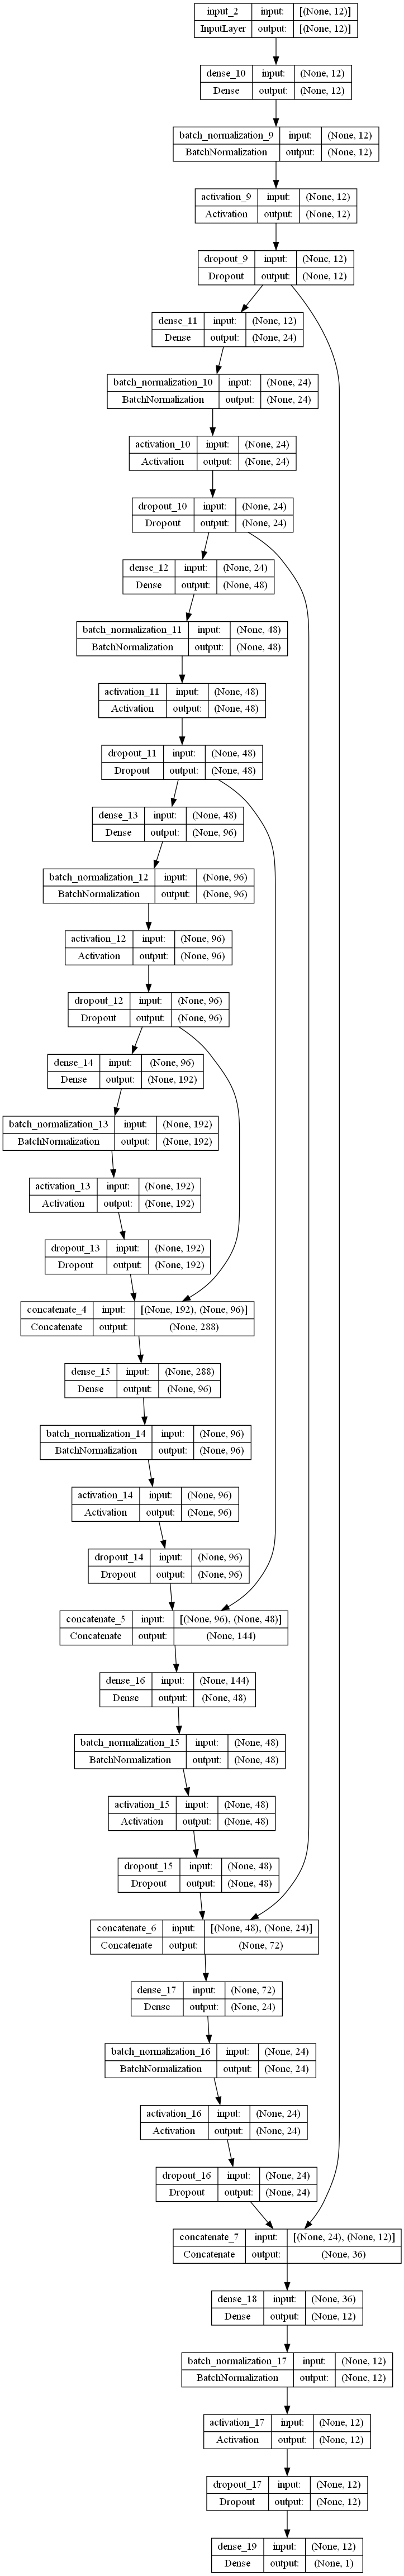

In [11]:
model = get_model(len(X_train.columns))
keras.utils.plot_model(model, show_shapes=True, to_file='model1_model.png')

In [12]:
# 얼리스타핑
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy'
                                        , min_delta=0.000001
                                        , patience=EPOCHS//2)

# 모델 저장
checkpoint_path = 'model1.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
                                        checkpoint_path
                                        , monitor='val_accuracy'
                                        , verbose=0
                                        , save_best_only=True
                                        , save_weights_only=True)

# 학습률 조정
lr_decay = keras.optimizers.schedules.CosineDecay(
                                        initial_learning_rate=0.01
                                        , decay_steps=EPOCHS
                                        , alpha=1e-12)
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# 모델 학습
history = model.fit(X_train, y_train
                , batch_size=MB_SIZE
                , validation_split = 0.2
                , verbose=0
                , epochs=EPOCHS
                , callbacks=[earlystop, checkpoint, CustomCallback(), lr_scheduler]
                )

# 가장 성능이 좋았던 모델을 가져와 평가
model.load_weights(checkpoint_path)
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss : {loss:.3f} / Accuracy  : {accuracy:.3f}')

Starting training

0 / 10 / 20 / 30 / 40 / 50 / 60 / 70 / 80 / 90 / 
100 / 110 / 120 / 130 / 140 / 150 / 160 / 170 / 180 / 190 / 
200 / 210 / 220 / 230 / 240 / 250 / 260 / 270 / 280 / 290 / 
300 / 310 / 320 / 330 / 340 / 350 / 360 / 370 / 380 / 390 / 
400 / 410 / 420 / 430 / 440 / 450 / 460 / 470 / 480 / 490 / 
500 / 510 / 520 / 530 / 540 / 550 / 560 / 570 / 580 / 590 / 
600 / 610 / 620 / 630 / 640 / 650 / 660 / 670 / 680 / 690 / 
700 / 710 / 720 / 730 / 740 / 750 / 760 / 770 / 780 / 790 / 
800 / 810 / 820 / 830 / 840 / 850 / End training
26/26 [==============================] - 0s 13ms/step - loss: 6.6513 - accuracy: 0.8510
Test Loss : 6.651 / Accuracy  : 0.851


In [13]:
import json
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist = hist.set_index('epoch')
hist.to_json('model1.json')

with open('model1.json') as json_file:
    json_file = json.loads(json_file.read())
model1_hist = pd.DataFrame(json_file)
model1_hist

,loss,accuracy,val_loss,val_accuracy,lr
0,99.539185,0.096919,108.250694,0.037048,0.010000
1,88.539452,0.140709,102.724030,0.062517,0.010000
2,81.411484,0.184301,94.419334,0.104408,0.010000
3,75.319550,0.219638,88.254456,0.137810,0.010000
4,69.389297,0.250666,85.456436,0.155122,0.010000
...,...,...,...,...,...
853,2.067524,0.901879,6.734575,0.834781,0.000524
854,1.929612,0.905087,6.643515,0.836246,0.000517
855,1.951137,0.895503,6.613679,0.836922,0.000510
856,2.252108,0.897834,6.572980,0.837137,0.000503


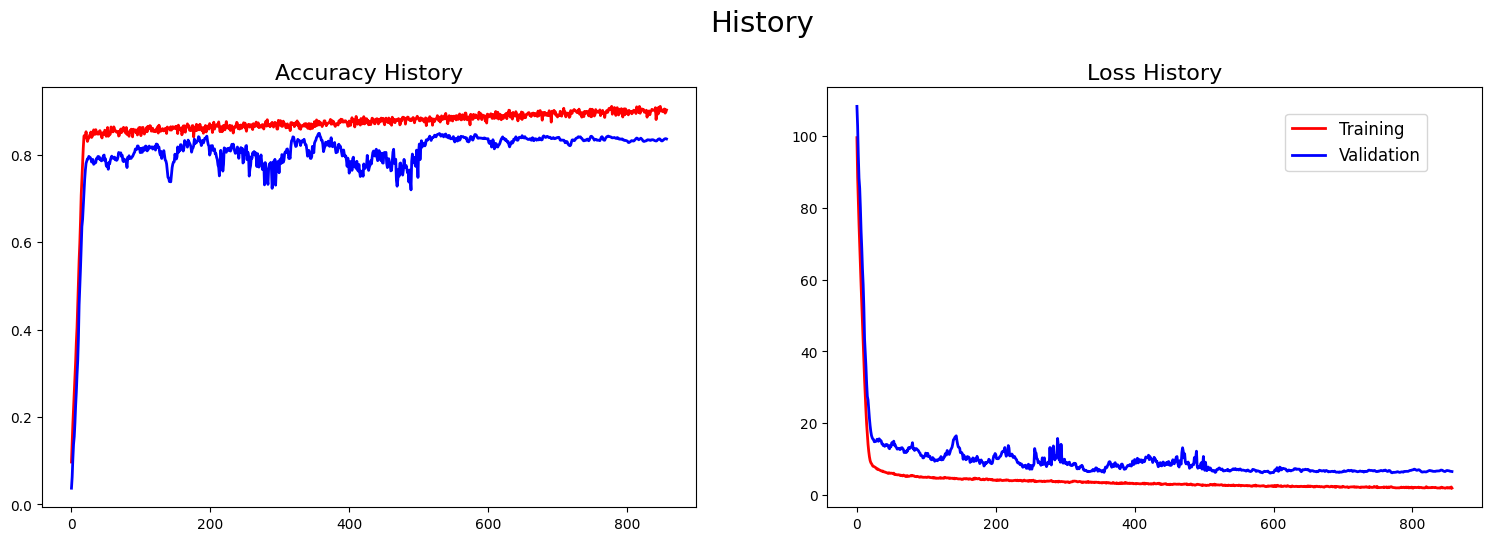

In [14]:
fig = plt.figure(figsize=(16, 6))
fig.suptitle('History', fontsize = 21)

# Accuracy Plot
ax = plt.subplot(1, 2, 1)
plt.title(f'Accuracy History', fontsize = 16, y = 1)
plt.plot(history.history["accuracy"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_accuracy"], color='b', linewidth=2, label="Validation")

# Loss Plot
ax = plt.subplot(1, 2, 2)
plt.title(f'Loss History', fontsize = 16, y = 1)
plt.plot(history.history["loss"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_loss"], color='b', linewidth=2, label="Validation")

plt.legend(fontsize=12, loc=(0.7, 0.8))
plt.subplots_adjust(right=0.95, left=0.05, top=0.85, bottom=0.15, wspace=0.2, hspace=0.2)
plt.show()

fig.savefig('model1_history.png', dpi=80, bbox_inches='tight')